In [1]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 15.0MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5269 sha256=c7429c19fa0fbe561e08f125feffe8f5bfbeb5471e70728fdcb8a31d42284222
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import torch.optim as optim
import numpy as np 
import torchvision
from torchvision import datasets, models, transforms
from torch.utils import model_zoo
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

import matplotlib.pyplot as plt 
import time 
import PIL
import collections
import math
import os 
import copy 
import re

In [0]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
test_norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    # nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Linear(256,3)
)
model.load_state_dict(torch.load('resnet34_covid.pth'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
configs = [
    dict(model_type='resnet', arch=model, layer_name='layer4')
]

In [0]:
for config in configs:
    config['arch'].eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [6]:
images = []

for i in range(1,3):
    img_name = 'img'+str(i)+'.jpeg'

    pil_image = PIL.Image.open(img_name)

    for gradcam, gradcam_pp in cams:
        img = test_transform(pil_image).to(device)
        normed_img = test_norm(img)[None]

        mask, _ = gradcam(normed_img)
        heatmap, result = visualize_cam(mask, img)

        images.extend([img.cpu(), result])
    
grid_image = make_grid(images, nrow=2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


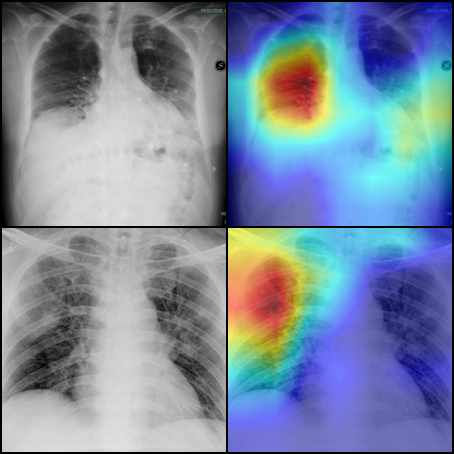

In [7]:
transforms.ToPILImage()(grid_image)